In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
MFCCs = np.load("../preprocessing/MFCCs/MFCC.npy")
MFCCs = (MFCCs - np.nanmean(MFCCs))/np.nanstd(MFCCs)

In [3]:
info_songs = pd.read_csv("../Info/info.csv")
label_songs = pd.read_csv("../preprocessing/labels.csv")

In [4]:
# Retrieve emotions from the labels.csv file

emotions = ["amazement", "solemnity", "tenderness", "nostalgia", "calmness", 
            "power", "joyful_activation", "tension", "sadness"]

labels = label_songs[emotions]
labels = labels.to_numpy()

length_songs = pd.DataFrame(info_songs["Track ID"])
length_songs["Song length"] = info_songs["Duration"]*10
length_songs["Song length"] = length_songs["Song length"].astype(int)

In [5]:
n_data = len(length_songs)
idx = np.random.permutation(n_data)
length_songs = length_songs.reindex(idx)["Song length"].to_numpy()
MFCCs_raw = MFCCs[idx, :, :]
labels_raw = labels[idx]

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

sample_size = (20, 50, 1)

drop_out_rate = 0.4

# very simple keras Sequential model
input_tensor = Input(sample_size)
x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(input_tensor)
x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(x)
x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(9, activation="sigmoid")(x)

model_1 = tf.keras.Model(input_tensor, output_tensor)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 48, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 46, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 16, 46, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 22, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 20, 16)         2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 9, 16)          0     

In [7]:
model = model_1

loss = "MSE"
#loss = "CosineSimilarity"
loss = "both"
loss = "KLDivergence"
loss = "RSquare"
loss = "LogCosh"

if loss == "MSE":
    model.compile(optimizer="adam",
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=["cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])
    
elif loss == "CosineSimilarity":
    model.compile(optimizer="adam",
                  loss= tf.keras.losses.CosineSimilarity(),
                  metrics=["MSE", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])
    
elif loss == "both":
    def custom_loss(y_true, y_pred):
        cos_sim = tf.keras.losses.CosineSimilarity() 
        MSE = tf.keras.losses.MeanSquaredError()
        return cos_sim(y_true, y_pred) + MSE(y_true, y_pred)
    
    model.compile(optimizer="adam",
                loss= custom_loss,
                metrics=["MSE", "cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])

elif loss == "KLDivergence":
    model.compile(optimizer="adam",
                loss = tf.keras.losses.KLDivergence(),
                metrics=["MSE", "cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])
    
elif loss == "RSquare":
    def rsquare_loss(y_true, y_pred):
        metric = tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))
        return -metric(y_true, y_pred)
    
    model.compile(optimizer="adam",
                loss = tf.keras.losses.KLDivergence(),
                metrics=["MSE", "cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])
    
elif loss == "LogCosh":
    model.compile(optimizer="adam",
                loss =  tf.keras.losses.LogCosh(),
                metrics=["MSE", "cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])

In [8]:
def slice_accordingly(input_tensor, labels, size=sample_size):

    input_shape = (tf.shape(input_tensor).numpy())
    
    input_shape[1], input_shape[2] = size[0], size[1]
    size = input_shape
    
    sliced_tensor = tf.image.random_crop(input_tensor, size)
    
    nan_values, idx = tf.unique(tf.gather(tf.where(tf.math.is_nan(sliced_tensor)), 0, axis=1))
    nan_values = nan_values.numpy()
  
    msk = np.zeros((input_shape[0]), dtype=np.bool)
    msk[nan_values] = True
    msk = ~msk

    sliced_tensor = tf.boolean_mask(sliced_tensor, msk , axis=0)
    labels = tf.boolean_mask(labels , msk, axis=0)
    
    return sliced_tensor, labels

In [9]:
fraction_validation = 0.25
n_test = int(fraction_validation*len(labels))
n_train = len(labels) - n_test

train_features, train_labels, train_length = MFCCs_raw[:n_train], labels_raw[:n_train], length_songs[:n_train]
validation_features, validation_labels, validation_length = MFCCs_raw[n_train:], labels_raw[n_train:], length_songs[n_train:]

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels, train_length))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels, validation_length))

In [11]:
n_epochs = 100
batch_size = 50

history_df = pd.DataFrame()

for epoch in range(n_epochs):
    print("Epoch", epoch)
    train_ds = train_dataset.shuffle(n_train).batch(batch_size)
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    
    x_val, y_val, length_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)
    
    for features, labels, lengths in train_ds:
        features, labels = slice_accordingly(features, labels)
        
        history = model.fit(features, labels,
                           validation_data=(x_val, y_val),verbose=1)
        history = pd.DataFrame(history.history)
        history_df = history_df.append(history)

Epoch 0
2/2 [==============================] - 0s 163ms/step - loss: 0.0394 - MSE: 0.0815 - cosine_similarity: 0.7068 - r_square: -1.9821 - val_loss: 0.0341 - val_MSE: 0.0699 - val_cosine_similarity: 0.7538 - val_r_square: -1.2566
Epoch 1
2/2 [==============================] - 0s 120ms/step - loss: 0.0365 - MSE: 0.0750 - cosine_similarity: 0.6951 - r_square: -2.1817 - val_loss: 0.0334 - val_MSE: 0.0682 - val_cosine_similarity: 0.7570 - val_r_square: -1.3363
Epoch 2
2/2 [==============================] - 0s 105ms/step - loss: 0.0338 - MSE: 0.0694 - cosine_similarity: 0.7334 - r_square: -1.7339 - val_loss: 0.0321 - val_MSE: 0.0654 - val_cosine_similarity: 0.7596 - val_r_square: -1.1985
Epoch 3
2/2 [==============================] - 0s 101ms/step - loss: 0.0287 - MSE: 0.0589 - cosine_similarity: 0.7328 - r_square: -1.2676 - val_loss: 0.0281 - val_MSE: 0.0574 - val_cosine_similarity: 0.7587 - val_r_square: -0.8271
Epoch 4
2/2 [==============================] - 0s 99ms/step - loss: 0.0282 -

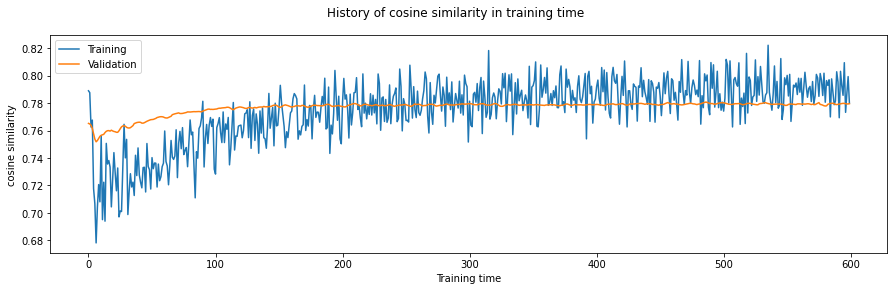

In [12]:
%matplotlib inline

metric = "cosine similarity" #Choose between 'loss', 'MSE', 'cosine similarity', 'r2'

import matplotlib.pyplot as plt
try: history_df = history_df.reset_index()
except: pass

metrics_dict = {"loss": ["loss", "val_loss"], "MSE": ["MSE", "val_MSE"], 
                "cosine similarity": ["cosine_similarity", "val_cosine_similarity"],
               "r2" : ["r_square", "val_r_square"]}

fig, ax = plt.subplots(figsize=(15,4),nrows=1, ncols=1)
ax.set_ylabel(f"{metric}")
ax.set_xlabel("Training time")
fig.suptitle(f"History of {metric} in training time")

train_plot = history_df.plot(y=metrics_dict[metric][0], use_index=True, ax=ax, label="Training")
val_plot = history_df.plot(y=metrics_dict[metric][1], use_index=True, ax=ax, label="Validation")

plt.show()

## Evaluation of the results

In [13]:
val_ds = validation_dataset.shuffle(n_test).batch(n_test)
x_val, y_val, length_val = next(iter(val_ds))
x_val, y_val = slice_accordingly(x_val, y_val)
    

y_pred = model.predict(x_val)
y_true = y_val

In [14]:
def plot_epsilon_error(y_true, y_pred):
    
    N = len(y_true)
    
    cdf_abs_error = {}
    abs_error = np.abs(y_true - y_pred)
    
    fig, ax = plt.subplots(figsize=(12,6),nrows=1, ncols=2)
    ax[0].set_ylabel("Fraction of samples")
    ax[0].set_xlabel("Allowed absolute error")
    ax[0].set_title(f"CDF of the absolute error for different emotions")
    
    for i, emotion in enumerate(emotions):
        abs_error_emotion = np.sort(abs_error[:,i])
        X2 = np.sort(abs_error_emotion)
        F2 = np.array(range(N))/(float(N))
        
        cdf_abs_error[emotion] = [X2, F2]
        
        ax[0].plot(X2, F2, label=emotion)
        
    ax[0].legend()
    ax[0].grid()
    
    cdf_cosine_sim = {}
    cos_sim = np.array([np.dot(y_true[i], y_pred[i])/(np.linalg.norm(y_true[i])*np.linalg.norm(y_pred[i])) for i in range(N)])
    cos_error = 1-cos_sim
    
    X2 = np.sort(cos_error)
    F2 = np.array(range(N))/(float(N))

    ax[1].set_ylabel(f"Fraction of samples", rotation=-90, labelpad=15)
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()
    ax[1].set_xlabel("Allowed cosine error")
    ax[1].set_title(f"CDF of the cosine error")
    
    ax[1].plot(X2, F2)
    ax[1].grid()
    return cdf_abs_error

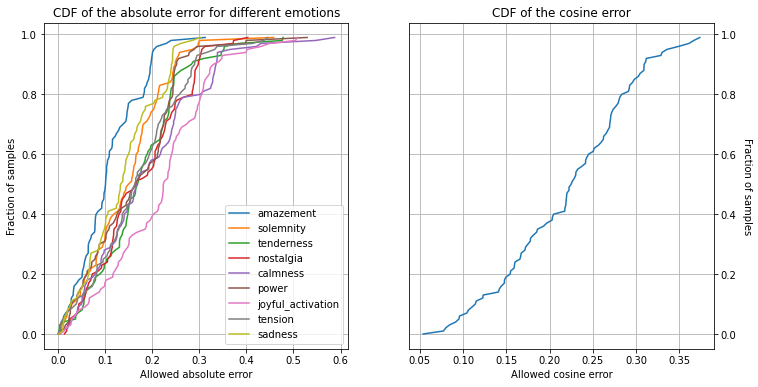

In [15]:
epsilon_error = plot_epsilon_error(y_true, y_pred)

x = epsilon_error["amazement"]
plt.show()

## "Cross-validation" 

In [16]:
def custom_loss(y_true, y_pred):
    cos_sim = tf.keras.losses.CosineSimilarity() 
    MSE = tf.keras.losses.MeanSquaredError()
        
    return cos_sim(y_true, y_pred) + MSE(y_true, y_pred)

In [18]:
from sklearn.model_selection import KFold


n_splits = 5
kf = KFold(n_splits=n_splits)

predictions_and_labels = {}


count = 0
for train_index, test_index in kf.split(MFCCs_raw):
    
    print(f"Training K-fold {1+count} of {n_splits}")

    train_features, train_labels = MFCCs_raw[train_index], labels_raw[train_index]
    validation_features, validation_labels = MFCCs_raw[test_index], labels_raw[test_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
    
    sample_size = (20, 50, 1)
    drop_out_rate = 0.4

    input_tensor = Input(sample_size)
    x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(input_tensor)
    x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(x)
    x = layers.Dropout(drop_out_rate)(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = layers.Conv2D(16, (3, 3), padding="valid", activation="relu", strides=1)(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(drop_out_rate)(x)
    output_tensor = layers.Dense(9, activation="sigmoid")(x)

    model = tf.keras.Model(input_tensor, output_tensor)
        
    model.compile(optimizer="adam",
                  loss = tf.keras.losses.LogCosh(),
                  #loss= custom_loss,
                  metrics=["MSE", "cosine_similarity", tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))])
    
    n_epochs = 100
    batch_size = 50
    
    for epoch in range(n_epochs):
        train_ds = train_dataset.shuffle(n_train).batch(batch_size)
        for features, labels in train_ds:
            features, labels = slice_accordingly(features, labels)
            model.fit(features, labels, verbose=0)
            
    val_ds = validation_dataset.shuffle(n_test).batch(n_test)
    x_val, y_val = next(iter(val_ds))
    x_val, y_val = slice_accordingly(x_val, y_val)

            
    predictions_and_labels[count] = [model.predict(x_val), y_val]
    count = count+1

Training K-fold 1 of 5
Training K-fold 2 of 5
Training K-fold 3 of 5
Training K-fold 4 of 5
Training K-fold 5 of 5


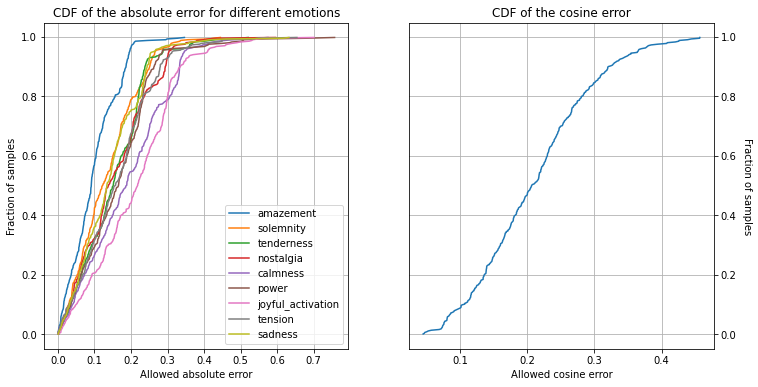

In [19]:
predictions = []
labels = []

for i in range(max(predictions_and_labels.keys())+1):
    predictions.append(predictions_and_labels[i][0])
    labels.append(predictions_and_labels[i][1])

predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
epsilon_error = plot_epsilon_error(labels, predictions)

plt.show()

In [20]:
cos_sim = []
r2 = []
MSE = []

cos_sim_function = tf.keras.metrics.CosineSimilarity() 
MSE_function = tf.keras.metrics.MeanSquaredError()
r2_function = tfa.metrics.RSquare(dtype=tf.float32, y_shape=(9,))

for i in range(max(predictions_and_labels.keys())+1):
    y_pred = predictions_and_labels[i][0]
    y_true = predictions_and_labels[i][1]
    
    cos_sim.append(cos_sim_function(y_true, y_pred).numpy())
    r2.append(r2_function(y_true, y_pred).numpy())
    MSE.append(MSE_function(y_true, y_pred).numpy())
    
print(f"The cosine similarity is approximately {100*np.mean(cos_sim):.2f}±{100*np.std(cos_sim):.2f}%")
print(f"The MSE is approximately {100*np.mean(MSE):.2f}±{100*np.std(MSE):.2f}%")
print(f"The R2 score is approximately {100*np.mean(r2):.2f}±{100*np.std(r2):.2f}%")

The cosine similarity is approximately 78.98±0.35%
The MSE is approximately 3.38±0.05%
The R2 score is approximately -9.84±1.23%
